In [127]:

# imaging with more data; template from wk2 folder
import astropy 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import ascii
from scipy.signal import convolve2d
import sys
import os

sys.path.append('/Users/georgiaalexakis/ToR - GitHub Repository/radio-eyes/wk5_analysis/')

from colourmap import spectral
cb_spec, cb_spec_r = spectral()

FWHM = 0.07913  / 12   # psf HWHM is an assumption
sigma_FWHM = FWHM / 2.355
HWHM = FWHM / 2
sigma_HWHM = HWHM/ 1.177



#put all the component fits files into an array
#component_array = ["1088284872", "1088284992", "1088285112", "1088285232", "1088285600",  "1088285720", "1088285848", "1088285968", "1088286088", "1088286208", "1088286336"]

# opens up the txt file 'more_data' and reads all the fits file names from that. 
#more_data = open('/Users/georgiaalexakis/ToR - GitHub Repository/radio-eyes/wk3/more_data.txt', 'r')
more_data = open('/Users/georgiaalexakis/ToR - GitHub Repository/radio-eyes/wk5_analysis/Deconvolution/observation_ids.txt', 'r')
#more_data_shit = [line.split( ) for line in more_data.readlines()]
component_array = [line.split( ) for line in more_data.readlines()]
# adds the more_data array at the end of the component_array
#for h in more_data_shit:
    #component_array = np.append(component_array, more_data_shit)
    
for i in component_array:
    #components = '/Users/georgiaalexakis/ToR - GitHub Repository/radio-eyes/wk3/more_data/' + i[0] +'_components.fits'
    components = '/Users/georgiaalexakis/ToR - GitHub Repository/radio-eyes/wk5_analysis/Deconvolution/' + i[0] +'_components.fits'
    hdu_list = fits.open(components, memmap=True)

    info_array = hdu_list[1].data

    ra = info_array['RIGHTASCENSION']
    dec = info_array['DECLINATION']
    flux = info_array['FLUXI']
    #used eyed instead of id since id is already a taken name
    eyed = info_array['ID']
    beam = info_array['BEAM']

    
    # appropriate range for ra is [340,10] which goes over the 360 boundary, to mitigate this we add an offset such that the effective ra range is [-20, 10]!
    ra[ra>180] -= 360


    # here i am setting up the initial data in the array by putting the data from the first fits file in the array.
    if component_array[0] == i:
        ra_overall = ra
        dec_overall = dec
        eyed_overall = eyed
        flux_overall = flux
        beam_overall = beam
    #for all else, it appends to the new variable to make a REALLY BIG ARRAY OF EVERYTHING EVER
    else:
        ra_overall = np.append(ra_overall, ra)
        dec_overall = np.append(dec_overall, dec)
        eyed_overall = np.append(eyed_overall, eyed)
        flux_overall = np.append(flux_overall, flux)
        beam_overall = np.append(beam_overall, beam)



#represents the total number of observations
n_obs = len(component_array)

def pixelate(ra_zoom, dec_zoom, n_bins, ra_overall, dec_overall, eyed_overall, flux_overall):

    #Check to see which dimension is larger so that a square in ra,dec can 
    #be returned
    if (ra_zoom[1]-ra_zoom[0]) > (dec_zoom[1]-dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1]-zoom[0])/n_bins

    #Create arrays for ra and dec that give the left side of each pixel
    ra_bin_array = np.multiply(range(n_bins), binsize) + ra_zoom[0]
    dec_bin_array = np.multiply(range(n_bins), binsize) + dec_zoom[0]

    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array),len(dec_bin_array)))

    #Histogram components into ra bins
    ra_histogram = np.digitize(ra_overall,ra_bin_array)

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(ra_bin_array) - 2):

        #Find the indices that fall into the current ra bin slice
        ra_inds = np.where(ra_histogram == bin_i)

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(ra_inds) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by dec
        dec_histogram = np.digitize(dec_overall[ra_inds],dec_bin_array)

        #Begin for loop by dec over ra bin slice
        for bin_j in range(len(dec_bin_array) - 2):
            
            #Find the indicies that fall into the current dec bin
            dec_inds = np.where(dec_histogram == bin_j)

            #Go to next for cycle if no indices fall into current dec bin			
            if len(dec_inds) == 0:
                continue

            #Sum the flux components that fall into current ra/dec bin
            pixels[bin_i,bin_j] = np.sum(flux_overall[(ra_inds[0])[dec_inds[0]]])

    #Find the pixel centers in ra/dec for plotting purposes
    ra_pixel_centers = np.multiply(range(n_bins),binsize) + ra_zoom[0] + binsize/2.
    dec_pixel_centers = np.multiply(range(n_bins),binsize) + dec_zoom[0] + binsize/2.

    return pixels, ra_pixel_centers, dec_pixel_centers




new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  8.435489833706106
tot flux 8.435489833706106


/var/folders/lh/gjdx4kyj4m9f7bzk50cysp6r0000gn/T/ipykernel_694/306138551.py:107: RuntimeWarning: divide by zero encountered in log
  min_flux = np.max(np.log(conv_image))
/var/folders/lh/gjdx4kyj4m9f7bzk50cysp6r0000gn/T/ipykernel_694/306138551.py:110: RuntimeWarning: divide by zero encountered in log
  min_flux_color = cb_spec(min_flux / np.min(np.log(conv_image)))
/var/folders/lh/gjdx4kyj4m9f7bzk50cysp6r0000gn/T/ipykernel_694/306138551.py:113: RuntimeWarning: divide by zero encountered in log
  vmin, vmax = np.percentile(np.log(conv_image), [30, 85])
/Users/georgiaalexakis/Library/Python/3.8/lib/python/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/lh/gjdx4kyj4m9f7bzk50cysp6r0000gn/T/ipykernel_694/306138551.py:123: RuntimeWarning: divide by zero encountered in log
  cax = ax.imshow(np.transpose(np.log(conv_image)), interpolation="nearest", origin="lower", cmap=cb_spec, vmin=vmin, vmax=vmax,


<Figure size 1000x1000 with 0 Axes>

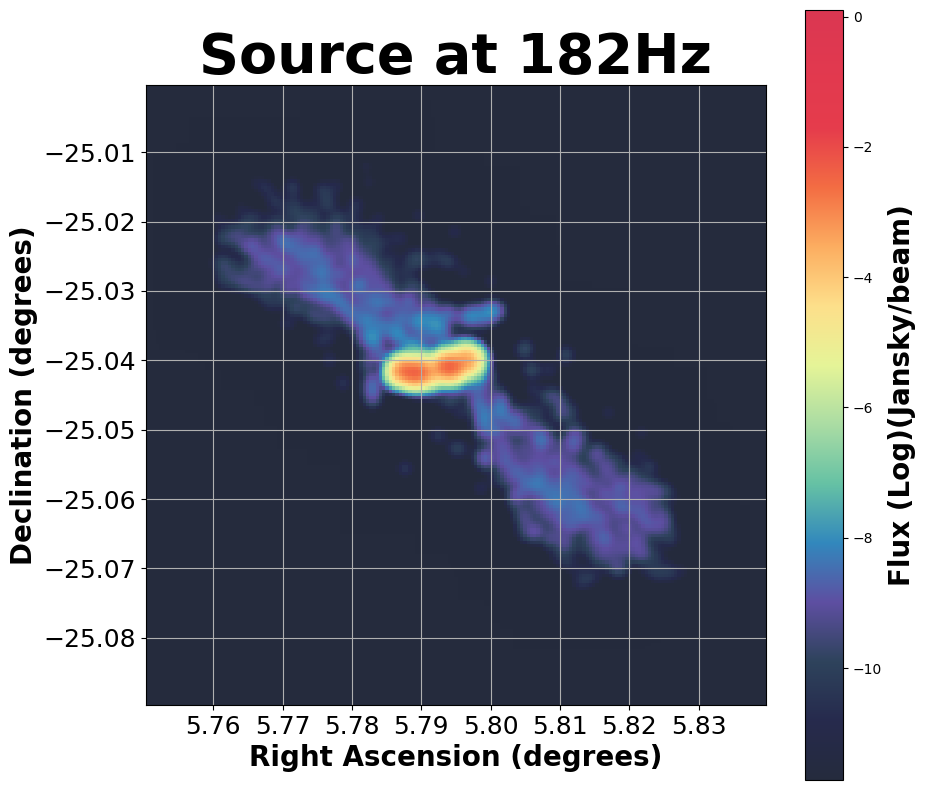

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  0.4108591731790392
tot flux 0.41085917317903925


<Figure size 1000x1000 with 0 Axes>

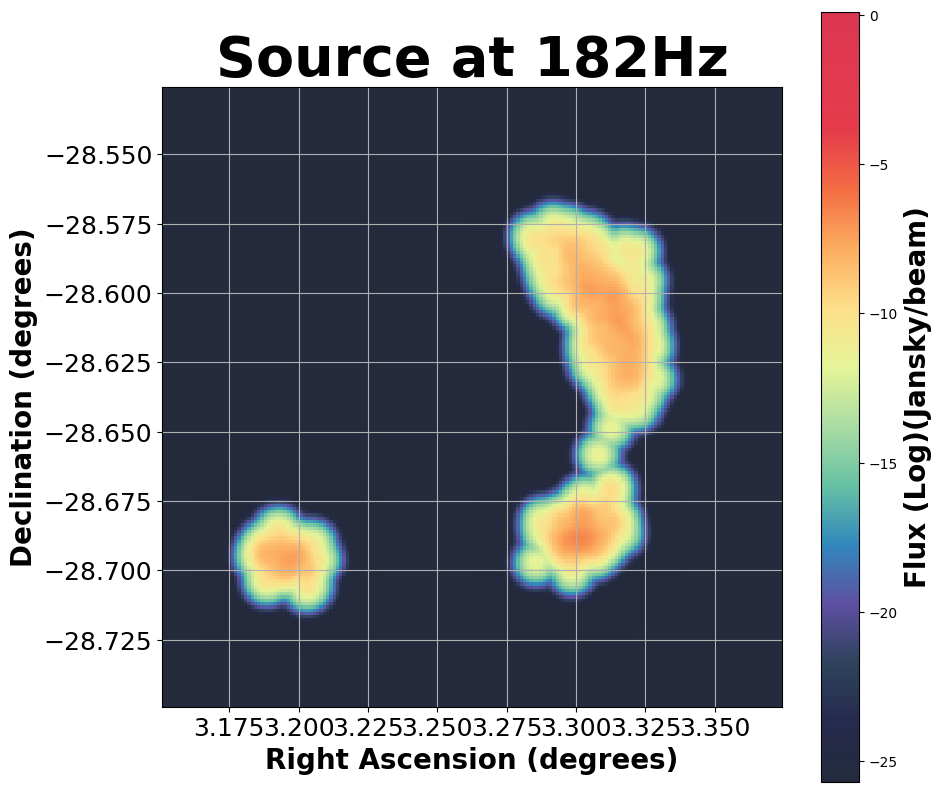

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  0.45956697934841517
tot flux 0.4595669793484153


<Figure size 1000x1000 with 0 Axes>

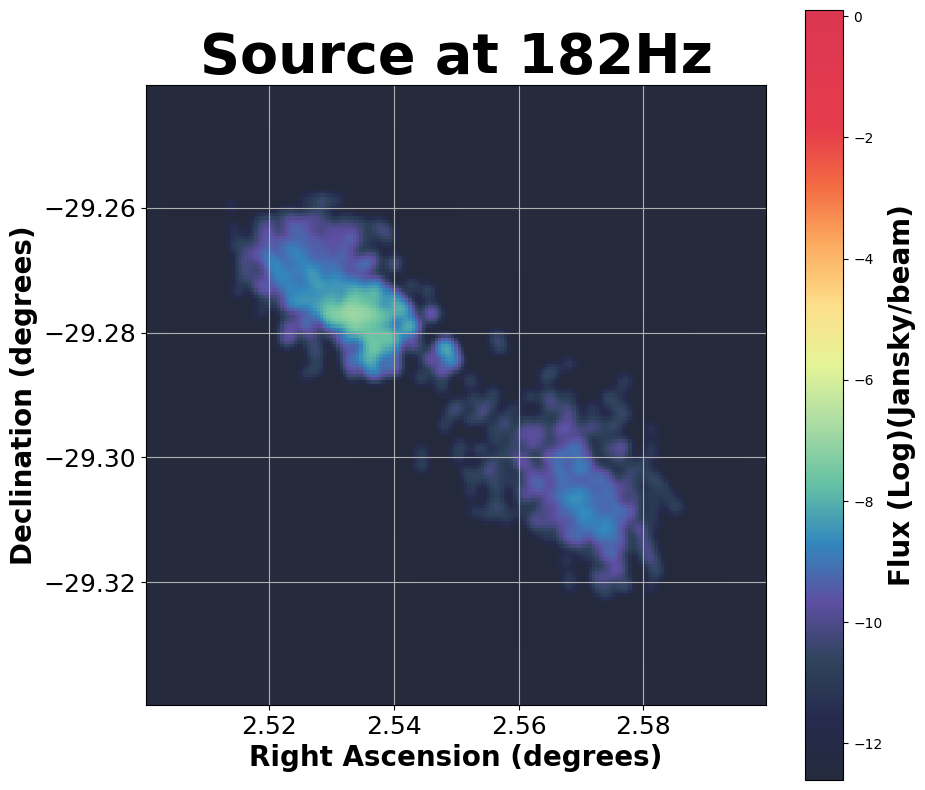

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  0.49871605918666384
tot flux 0.4987160591866639


<Figure size 1000x1000 with 0 Axes>

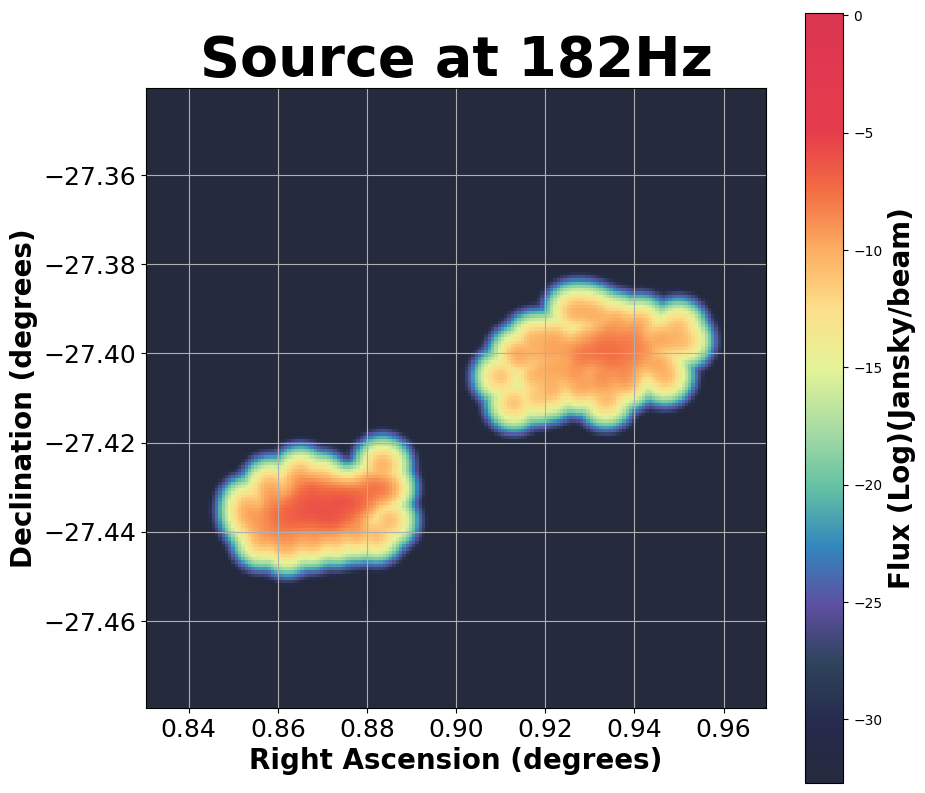

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  8.546094215795643
tot flux 8.546094215795643


<Figure size 1000x1000 with 0 Axes>

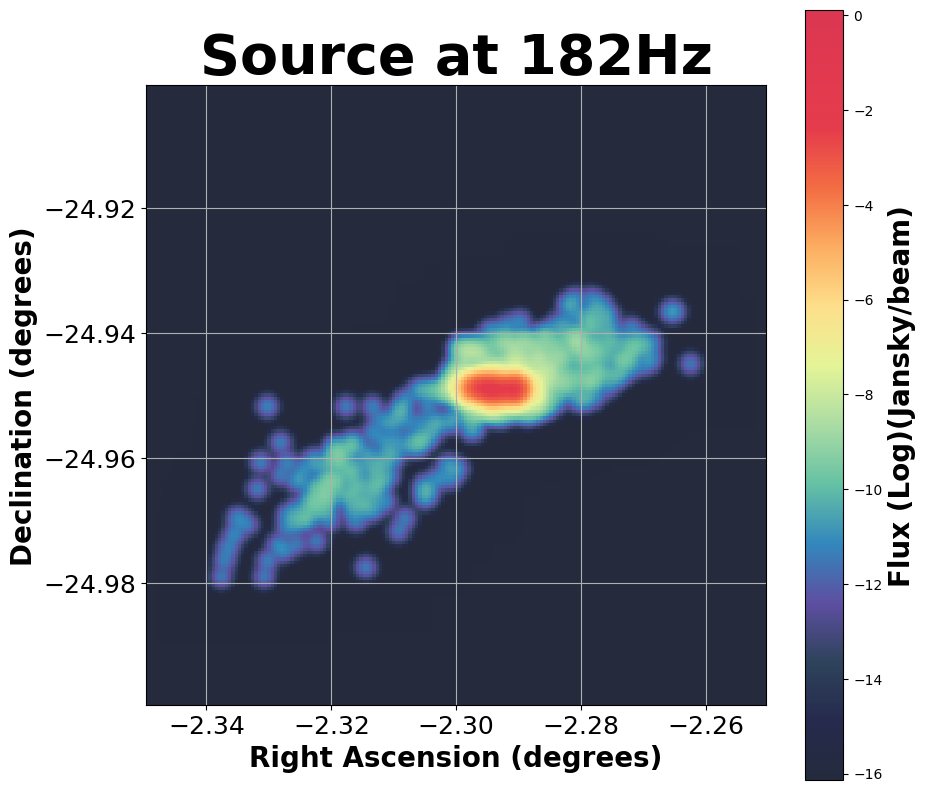

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  1.1972580032697955
tot flux 1.1972580032697955


<Figure size 1000x1000 with 0 Axes>

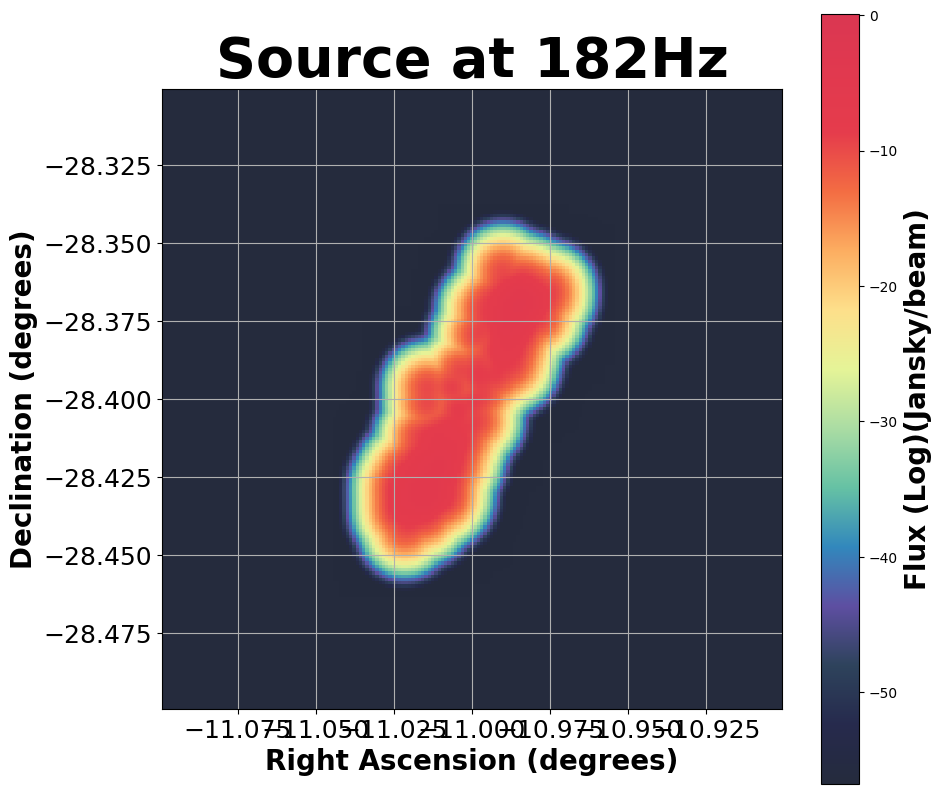

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  12.629943053864064
tot flux 12.629943053864068


<Figure size 1000x1000 with 0 Axes>

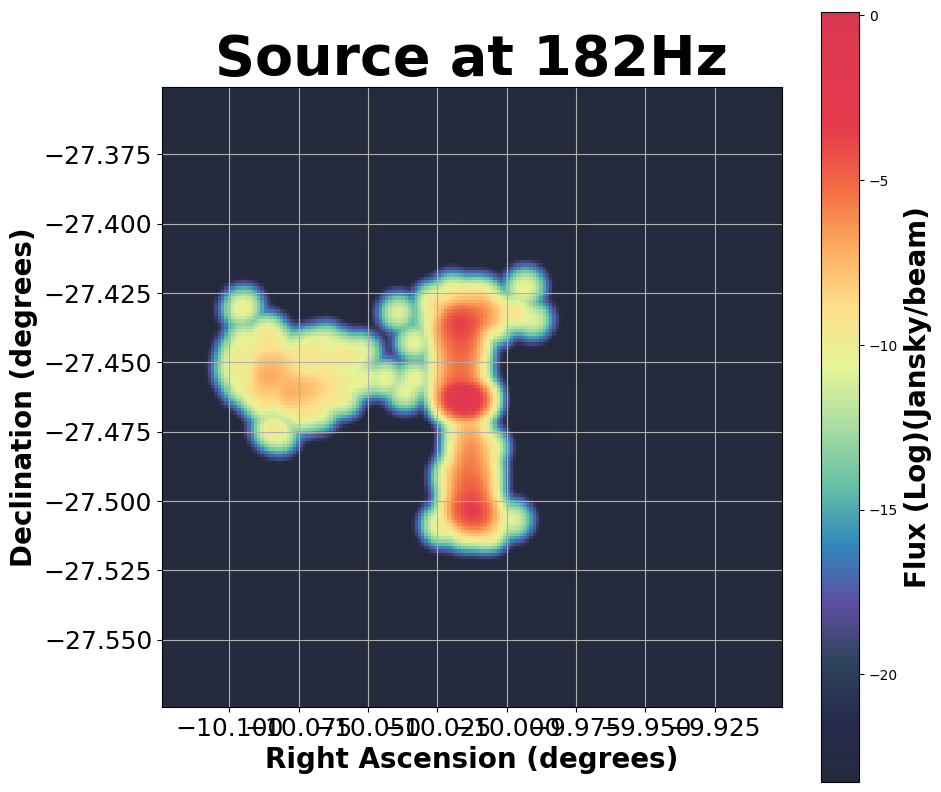

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  0.2590844922958583
tot flux 0.25908449229585834


<Figure size 1000x1000 with 0 Axes>

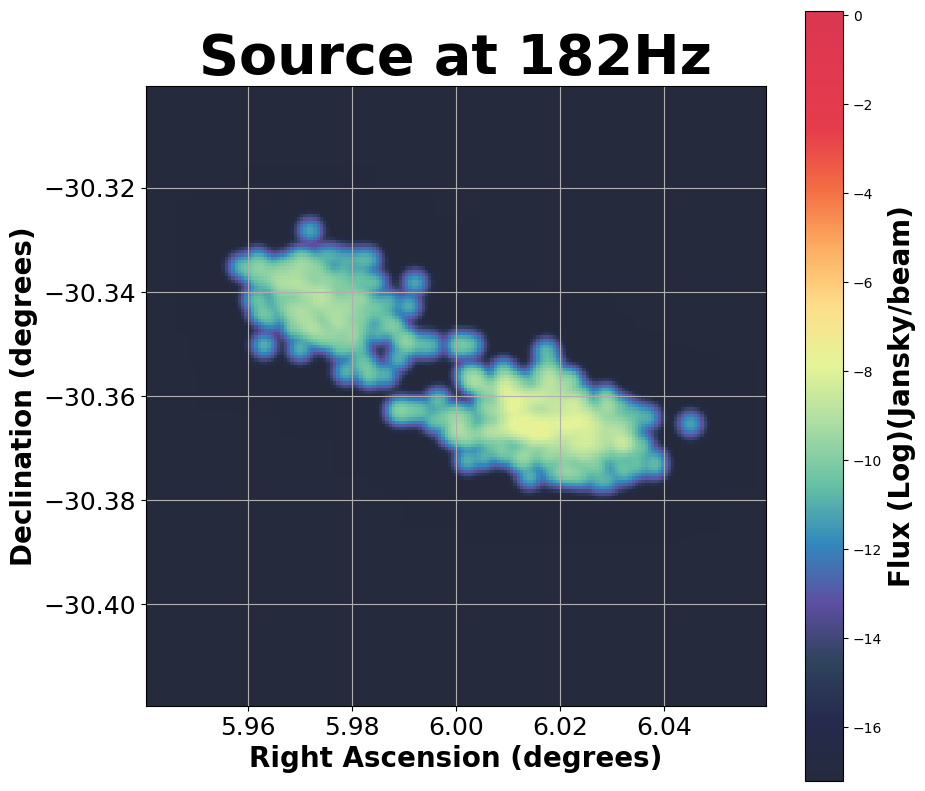

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  18.39487468396298
tot flux 18.39487468396298


<Figure size 1000x1000 with 0 Axes>

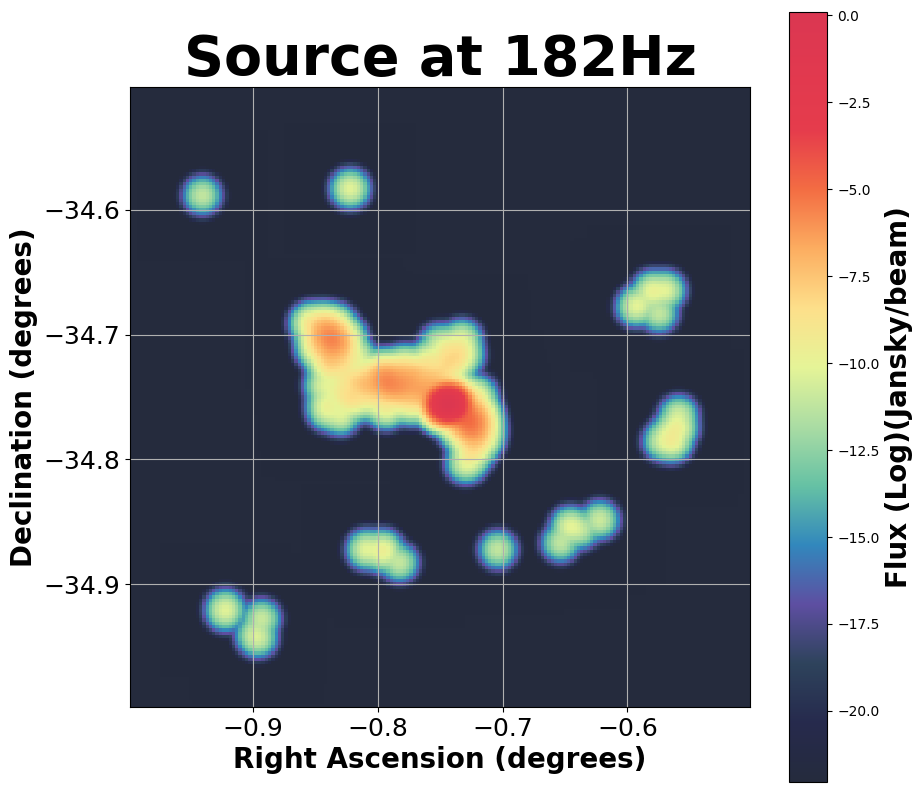

new_sigma =  1.8667138476055705
normalized ker mult. amplitude :
 [[1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 ...
 [7.58236422e-45 1.76932879e-42 3.09870808e-40 ... 3.09870808e-40
  1.76932879e-42 7.58236422e-45]
 [4.32944795e-47 1.01026760e-44 1.76932879e-42 ... 1.76932879e-42
  1.01026760e-44 4.32944795e-47]
 [1.85536184e-49 4.32944795e-47 7.58236422e-45 ... 7.58236422e-45
  4.32944795e-47 1.85536184e-49]]
ker 1.0000000000000002
flux sum:  12.257908654750372
tot flux 12.25790865475037


<Figure size 1000x1000 with 0 Axes>

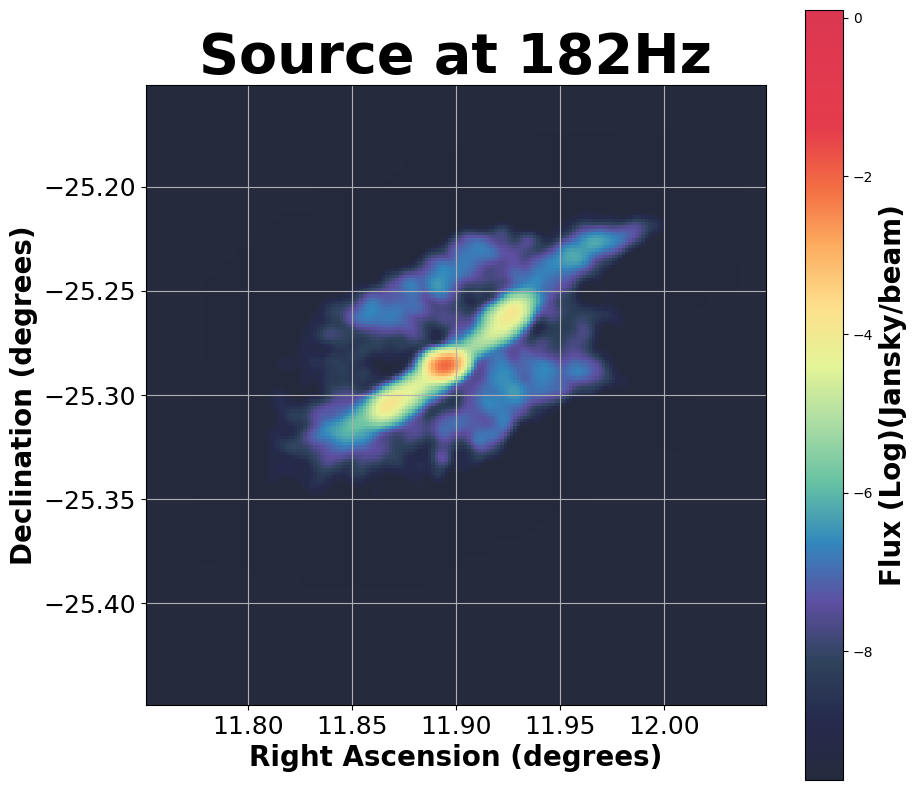

In [129]:
def gaussian_kernel(size, new_sigma):
    # make 1D array of equally spaced intervals
    array = np.linspace((-(size - 1) / 2), ((size - 1) / 2), size)
    # turns 1D array into 2D Kernel thingy
    x, y = np.meshgrid(array, array)
    kernel = np.exp(-0.5 * (np.square(x) + np.square(y)) / np.square(new_sigma))
    amplitutde = 1/(np.square(new_sigma)*2*np.pi)
    #print("exp:",( -0.5 * (np.square(x) + np.square(y)) / np.square(new_sigma)))
    #print("kernel\n", kernel)
    s = kernel #/ np.sum(kernel)
    amp = s * amplitutde

    print("normalized ker mult. amplitude :\n", amp)
    return amp


FWHM = 0.07913  / 30  # psf HWHM is an assumption 8, 24
sigma_FWHM = FWHM / 2.355
HWHM = FWHM / 2
sigma_HWHM = HWHM/ 1.177


#for loop here to loop through all the sources
#centre the sources so each source is the same number of pixels and therefore has the same ra and dec [5.95, 6.05]

ra_sources = [[5.75, 5.84], [3.15, 3.375], [2.50, 2.60], [0.83, 0.97], [-2.35, -2.25], [-11.10, -10.90], [-10.125, -9.90], [5.94, 6.06], [-1.00, -0.50], [11.75, 12.05]]
dec_sources = [[-25.09,-25], [-28.75,-28.525], [-29.34,-29.24],[-27.48,-27.34],[-25,-24.9], [-28.5,-28.3],[-27.575,-27.35 ], [-30.42,-30.3],[-35,-34.5], [-25.45, -25.15]]
n_bins = 150

#expand_amount = 0.2
#def expand_range(pairs, amount):
    #expanded = []
    #for pair in pairs:
       # midpoint = (pair[0] + pair[1]) / 2
        #half_range = (pair[1] - pair[0]) / 2
       # new_half_range = half_range + amount / 2
        #expanded.append([midpoint - new_half_range, midpoint + new_half_range])
    #return expanded

# Expanded RA and Dec sources
#expanded_ra_sources = expand_range(ra_sources, expand_amount)
#expanded_dec_sources = expand_range(dec_sources, expand_amount)



#create a loop to find the difference between the 2nd and first components of each element in the array to find the degree range
degree_range = []
for pair in dec_sources:
    diff = pair[1] - pair[0]
    degree_range.append(diff)

counter = 0
#count = 0


for ra_zoom, dec_zoom in zip(ra_sources, dec_sources):

    range_of_ra_dec = np.where((ra_overall >= ra_zoom[0]) & (ra_overall <= ra_zoom[1]) & (dec_overall >= dec_zoom[0]) & (dec_overall <= dec_zoom[1]))
    
    new_ra = ra_overall[range_of_ra_dec]
    new_dec = dec_overall[range_of_ra_dec]
    new_flux = flux_overall[range_of_ra_dec]
    new_eyed = eyed_overall[range_of_ra_dec]
    new_beam = beam_overall[range_of_ra_dec]


    (pixels, ra_pixel_centers, dec_pixel_centers) = pixelate(ra_zoom, dec_zoom, n_bins, new_ra, new_dec, new_eyed, new_flux)

    pixels2 = pixels / n_obs
    num = np.size(pixels2)
    

# divide num of pixels by the degree range so wehave pixels/deg then multiply with sigma_HWHM so we have the sigma in the unit of pixels then pass that through the function
   # max_sigma = 1.33
    new_sigma =  (np.sqrt(num) / (degree_range[counter]) * (sigma_FWHM))
    counter += counter
    print("new_sigma = ", new_sigma)
    size = 40 # 90
    kernel = gaussian_kernel(size, new_sigma)
    kernel_sum = np.sum(kernel)
    print("ker", kernel_sum)
    print("flux sum: ", np.sum(pixels2))
    conv_image = convolve2d(pixels2,kernel)
    print("tot flux", np.sum(conv_image))

    with open('flux_data_.txt', 'a') as file:
    # Iterate through the pixel centers and their corresponding flux values
        for i, ra in enumerate(ra_pixel_centers):
            for j, dec in enumerate(dec_pixel_centers):
                flux_value = conv_image[i, j]
            # Write the RA, Dec, and flux value to the file
                file.write(f"RA: {ra}, Dec: {dec}, Flux: {flux_value}\n")

        # Write source information
        file.write(f"source {counter}\n")



    

#dec as y, ra as x

#figsize scales the plot, in this case i chose 10,10 square so its relatively big and easy to see!
    plt.figure(figsize=(10,10))

    # Find the minimum flux value in the convolved image
    min_flux = np.max(np.log(conv_image))

# Get the color corresponding to the minimum flux value from the colormap
    min_flux_color = cb_spec(min_flux / np.min(np.log(conv_image)))
    #vmin, vmax = np.percentile(np.log(conv_image), [0, 100])
    #min_flux_colour = (vmax/vmin)
    vmin, vmax = np.percentile(np.log(conv_image), [30, 85]) 
    # Good images ;-;
    # source 10: [30,85] at FWHM/30 and ker_size = 40

# Plot the image with the specified background color
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor(min_flux_color)

    

    cax = ax.imshow(np.transpose(np.log(conv_image)), interpolation="nearest", origin="lower", cmap=cb_spec, vmin=vmin, vmax=vmax,
                extent=[ra_pixel_centers[0], ra_pixel_centers[-1], 
                        dec_pixel_centers[0], dec_pixel_centers[-1]])

# Set labels and title with desired font sizes
    ax.set_xlabel('Right Ascension (degrees)', fontweight='bold', size=20)
    ax.set_ylabel('Declination (degrees)', fontweight='bold', size=20)
    ax.set_title('Source at 182Hz', fontweight='bold', size=40)
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
# Add colorbar
    cbar = fig.colorbar(cax)
    cbar.set_label('Flux (Log)(Jansky/beam)', size=20, fontweight='bold')

# Add grid
    ax.grid(True)

# Show the plot
    plt.show()

#imshow is a type of plot that shows the image (duh)
#took the log of the flux scale which made things happen
#interpolation made the pixels not fuzzy
#origin reoriented the y axis so it goes from 0 to 100 instead of 100 to 0
#cmap changed the colorbar so that the colors are sequentially dark-light in relation to flux
#    plt.imshow(np.transpose(np.log(conv_image)), interpolation = "nearest", origin = "lower", cmap = cb_spec, 
#          extent = [ra_pixel_centers[0], ra_pixel_centers[len(ra_pixel_centers)-1], 
#           dec_pixel_centers[0], dec_pixel_centers[len(dec_pixel_centers)-1]])

#the x and y axis labels are not accurate right now but that's okay :)
 #   plt.xlabel('Right Ascention (degrees)', fontweight='bold', size=20)
 #   plt.ylabel('Declination (degrees)', fontweight='bold', size=20)
 #   plt.title('Source at 182Hz ', fontweight='bold', size = 40)

  #  plt.colorbar()
  #  plt.grid()
  #  plt.show()


    #fill the background with the darkest flux val
    # increase font
    # right ascention
    # units on colour bar

0.7852702
